
[ANALYSIS] Running Fundamental Diagram Analysis...


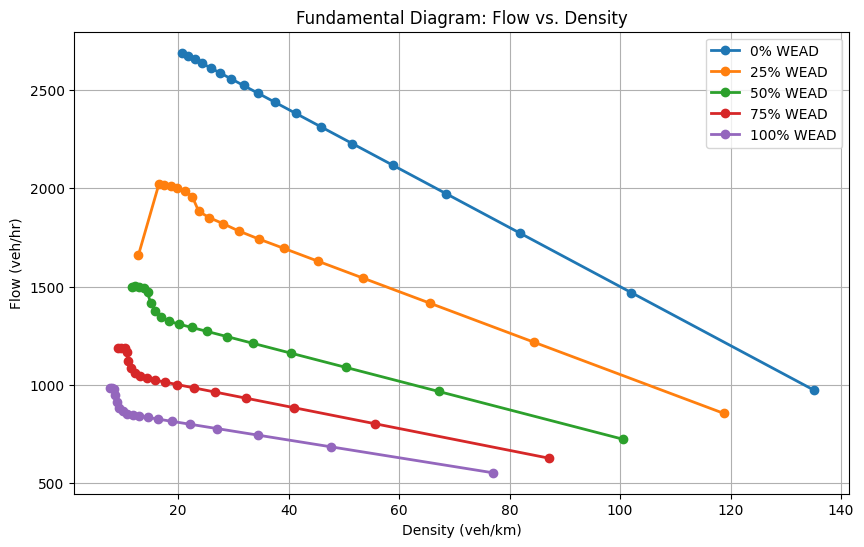


[ANALYSIS] Running Stability & Energy Analysis...


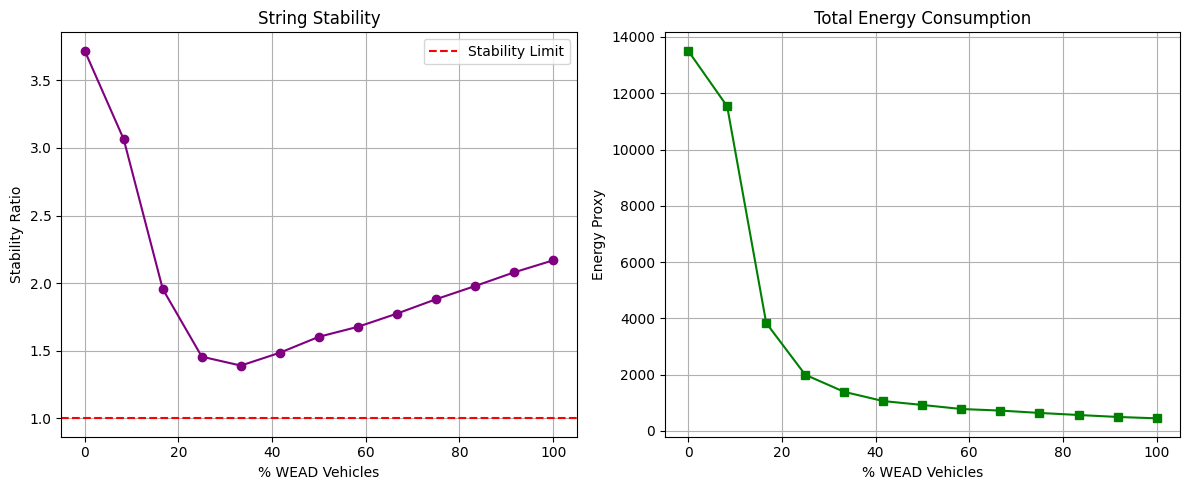


[EXECUTION] Running Standard Stop-and-Go Scenario (3 WEAD cars)...


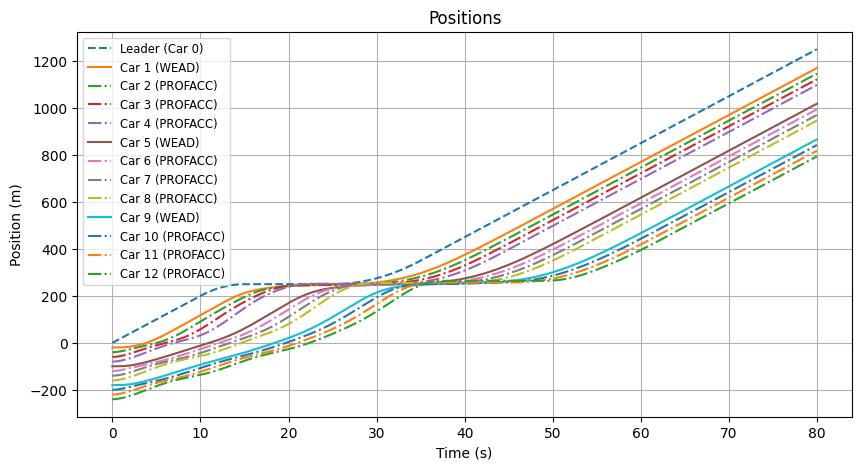

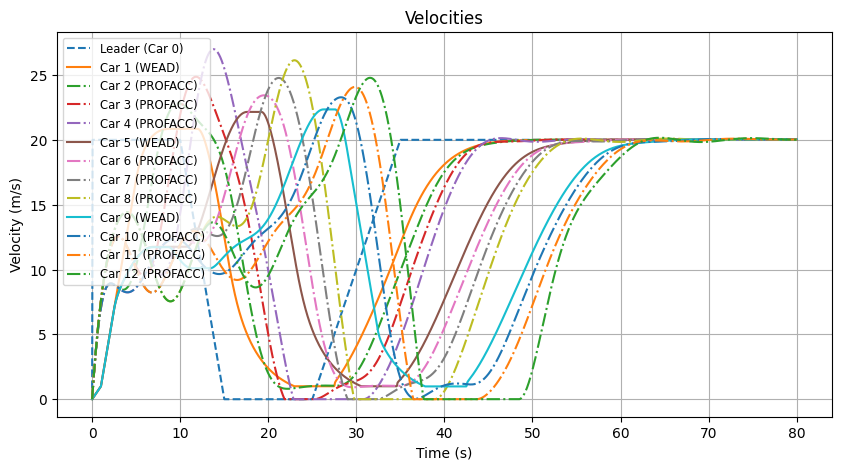

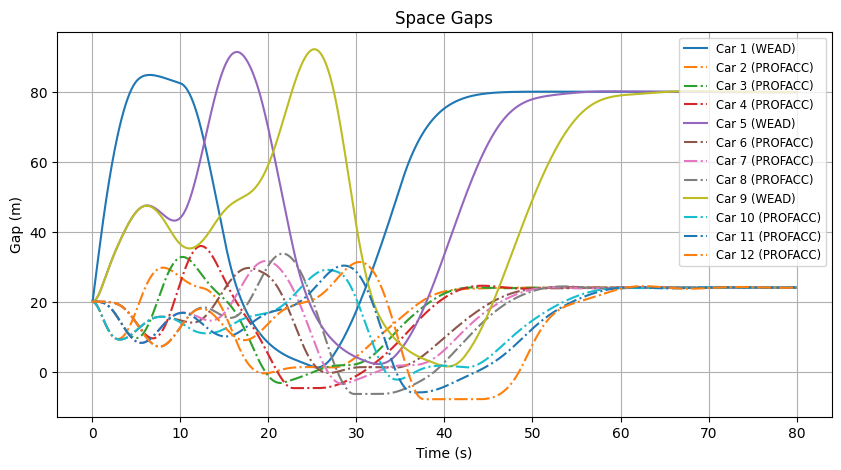

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
#  0. GLOBAL CONFIGURATION
# ============================================================
NUM_FOLLOWERS = 12              # 12 Following Vehicles
TOTAL_CARS = NUM_FOLLOWERS + 1  # 1 Leader + 12 Followers = 13 Total

# ============================================================
#  1. CONTROLLER LOGIC
# ============================================================

def wead_controller(sn, vn):
    """
    WEAD Controller:
    - Uses space-gap logic at low speeds/stops.
    - Uses smoothed time-gap logic at driving speeds.
    - Converted from MATLAB.
    """
    # Parameters
    STOPPED_SPEED_TH = 1.0
    STOPPED_MIN_GAP = 5.0
    STOPPED_ACCEL = 1.0
    
    MAX_ACCEL = 4
    MAX_BRAKE = -4 
    
    CRUISE_SPEED_LIMIT = 36.0
    CRUISE_RAMP_START = 34.0

    # --- State 1: Stopped Logic ---
    if vn <= STOPPED_SPEED_TH:
        if sn > STOPPED_MIN_GAP:
            return STOPPED_ACCEL
        else:
            return 0.0

    # --- State 2: Moving Logic ---
    # Calculate Time Gap
    # Avoid division by zero
    time_gap = sn / vn if vn > 0.1 else 20.0

    if time_gap <= 3:
        # Full Brake
        return MAX_BRAKE
        
    elif time_gap < 3.5:
        # Ramp from (3, MAX_BRAKE) to (3.5, 0)
        # Slope calculation ensures continuity regardless of MAX_BRAKE value
        slope = (0 - MAX_BRAKE) / (3.5 - 3.0) # e.g. 3 / 0.5 = 6
        return slope * (time_gap - 3.5)
        
    elif time_gap <= 4.0:
        # Dead band (Coast)
        return 0.0
        
    elif time_gap < 5.0:
        # Ramp from (4.0, 0) to (5.0, MAX_ACCEL)
        # Slope calculation ensures continuity regardless of MAX_ACCEL value
        slope = (MAX_ACCEL - 0) / (5.0 - 4.0) 
        return slope * (time_gap - 4.0)
        
    elif time_gap >= 5.0:
        # Cruise Speed Control
        if vn <= CRUISE_RAMP_START:
            return MAX_ACCEL
        elif vn < CRUISE_SPEED_LIMIT:
            # Linear ramp down acceleration near speed limit
            # From (CRUISE_RAMP_START, MAX_ACCEL) to (CRUISE_SPEED_LIMIT, 0)
            slope = (0 - MAX_ACCEL) / (CRUISE_SPEED_LIMIT - CRUISE_RAMP_START)
            return slope * (vn - CRUISE_SPEED_LIMIT)
        else:
            return 0.0

    return 0.0

def profacc_controller(sn, vn, alpha=0.5, tau=1.2):
    """
    Standard baseline controller (Constant Time Gap).
    Includes a braking limit to match WEAD safety constraints if desired.
    """
    return alpha * (sn - tau * vn)


# ============================================================
#  2. SCENARIO HELPERS (Leader Profiles & Ordering)
# ============================================================

def get_leader_velocity(t, profile_type, target_speed=20.0):
    """
    Defines how the leader (Car 0) behaves.
    """
    if profile_type == "constant":
        # For Fundamental Diagram: Ramps to target and holds.
        if t < 20:
            # Slow ramp up to avoid shockwaves at start
            return (target_speed / 20.0) * t
        else:
            return target_speed
            
    elif profile_type == "sine_wave":
        # For Stability Analysis: Oscillates to test dampening.
        base_speed = 20.0
        return base_speed + 3.0 * np.sin(0.3 * t)
    
    elif profile_type == "stop_and_go":
        # For Standard Plots: Stops and recovers.
        if t < 10: return 20.0
        elif t < 15: return max(0, 20.0 - 4.0 * (t-10)) # Brake
        elif t < 25: return 0.0                         # Wait
        else: return min(20.0, (t-25) * 2.0)            # Recover
        
    return 20.0

def assign_controllers(num_wead, ordering="interspersed"):
    """
    Creates a list of controller types for the platoon.
    Index 0 is 'LEADER'. Indices 1-12 are the followers.
    """
    # Clamp input
    num_wead = max(0, min(num_wead, NUM_FOLLOWERS))
    
    controllers = ["PROFACC"] * NUM_FOLLOWERS

    if ordering == "interspersed":
        if num_wead > 0:
            # Distribute WEAD cars evenly
            spacing = NUM_FOLLOWERS / num_wead
            for i in range(num_wead):
                idx = int(i * spacing)
                if idx < NUM_FOLLOWERS:
                    controllers[idx] = "WEAD"
    
    # Prepend LEADER
    return ["LEADER"] + controllers


# ============================================================
#  3. SIMULATION ENGINE
# ============================================================

def simulate_platoon(num_wead_cars, profile_type, T=60, init_spacing=20.0, target_speed=20.0):
    """
    Main simulation loop.
    Returns time history of positions, velocities, accelerations, and gaps.
    """
    dt = 0.05
    N = int(T/dt)
    t = np.linspace(0, T, N)
    
    # 1. Setup Controllers
    controllers = assign_controllers(num_wead_cars)

    # 2. Initialize Arrays
    x = np.zeros((TOTAL_CARS, N))
    v = np.zeros((TOTAL_CARS, N))
    a = np.zeros((TOTAL_CARS, N))
    space_gaps = np.zeros((TOTAL_CARS, N))
    time_gaps  = np.zeros((TOTAL_CARS, N))

    # 3. Initial Conditions
    for i in range(TOTAL_CARS):
        x[i, 0] = -init_spacing * i
        v[i, 0] = 0.0 # Start from stop to allow stabilization
        if i > 0:
            space_gaps[i, 0] = init_spacing

    # 4. Time Step Loop
    for k in range(1, N):
        
        # --- Update Leader (Car 0) ---
        v[0, k] = get_leader_velocity(t[k], profile_type, target_speed)
        x[0, k] = x[0, k-1] + v[0, k] * dt
        
        # --- Update Followers (Cars 1 to 12) ---
        for i in range(1, TOTAL_CARS):
            # Inputs
            sn = x[i-1, k-1] - x[i, k-1]  # Space to car ahead
            vn = v[i, k-1]                # Current speed
            
            # Record Metrics
            space_gaps[i, k] = sn
            time_gaps[i, k] = sn / vn if vn > 0.1 else 20.0 # Cap for plotting
            
            # Get Controller Command
            ctype = controllers[i]
            if ctype == "WEAD":
                acc = wead_controller(sn, vn)
            else:
                acc = profacc_controller(sn, vn)
            
            # Physics Update
            a[i, k] = acc
            v[i, k] = max(0, v[i, k-1] + acc * dt) # No reversing
            x[i, k] = x[i, k-1] + v[i, k] * dt
            
    return t, x, v, a, space_gaps, time_gaps, controllers


# ============================================================
#  4. ANALYSIS: STANDARD PLOTS
# ============================================================

def run_standard_platoon_plots(num_wead_cars, T=60):
    """
    Runs a 'Stop-and-Go' scenario and plots Position, Velocity, Space Gap.
    """
    print(f"\n[EXECUTION] Running Standard Stop-and-Go Scenario ({num_wead_cars} WEAD cars)...")
    
    t, x, v, a, s_gaps, t_gaps, controllers = simulate_platoon(
        num_wead_cars, profile_type="stop_and_go", T=T
    )

    def get_style(idx, ctype):
        if idx == 0: return '--', "Leader (Car 0)"
        if ctype == "WEAD": return '-', f"Car {idx} (WEAD)"
        return '-.', f"Car {idx} (PROFACC)"
    
    # 1. Positions
    plt.figure(figsize=(10, 5))
    for i in range(TOTAL_CARS):
        style, lbl = get_style(i, controllers[i])
        plt.plot(t, x[i], linestyle=style, label=lbl)
    plt.title("Positions")
    plt.xlabel("Time (s)"); plt.ylabel("Position (m)")
    plt.grid(); plt.legend(loc='upper left', fontsize='small')
    plt.show()

    # 2. Velocities
    plt.figure(figsize=(10, 5))
    for i in range(TOTAL_CARS):
        style, lbl = get_style(i, controllers[i])
        plt.plot(t, v[i], linestyle=style, label=lbl)
    plt.title("Velocities")
    plt.xlabel("Time (s)"); plt.ylabel("Velocity (m/s)")
    plt.grid(); plt.legend(loc='upper left', fontsize='small')
    plt.show()
    
    # 3. Space Gaps (Only followers have gaps)
    plt.figure(figsize=(10, 5))
    for i in range(1, TOTAL_CARS):
        style, lbl = get_style(i, controllers[i])
        plt.plot(t, s_gaps[i], linestyle=style, label=lbl)
    plt.title("Space Gaps")
    plt.xlabel("Time (s)"); plt.ylabel("Gap (m)")
    plt.grid(); plt.legend(loc='upper right', fontsize='small')
    plt.show()



# ============================================================
#  5. ANALYSIS: FUNDAMENTAL DIAGRAM
# ============================================================

def run_fundamental_diagram_analysis():
    """
    Sweeps target speeds to generate Density vs. Flow curves for various penetration rates.
    """
    print("\n[ANALYSIS] Running Fundamental Diagram Analysis...")
    
    # Test speeds from 2 to 36 m/s
    target_speeds = np.arange(2, 38, 2) 
    
    # Define exact penetration scenarios based on 12 followers
    # 0%, 25%, 50%, 75%, 100%
    scenarios = {
        "0% WEAD": 0,
        "25% WEAD": 3,  # 3 out of 12
        "50% WEAD": 6,  # 6 out of 12
        "75% WEAD": 9,  # 9 out of 12
        "100% WEAD": 12 # All 12
    }
    
    plt.figure(figsize=(10, 6))
    
    for label, num_wead in scenarios.items():
        densities = [] # k (veh/km)
        flows = []     # q (veh/hr)
        
        for v_target in target_speeds:
            # Use dynamic spacing to ensure stability at high speeds
            # Start with spacing roughly equal to 3 seconds * speed to reduce transient time
            smart_spacing = max(10.0, 3.0 * v_target)
            
            # Run simulation with constant speed profile
            # T=200 ensures we have plenty of time to settle into steady state
            _, x, v, _, _, _, _ = simulate_platoon(
                num_wead, profile_type="constant", T=200, 
                init_spacing=smart_spacing, target_speed=v_target
            )
            
            # STEADY STATE CALCULATION:
            # Use the last 40 seconds of the simulation to average the results
            last_steps = int(40 / 0.05)
            
            # 1. Average Velocity (Flow speed)
            # Average speed of all followers over the steady window
            avg_v_platoon = np.mean(v[1:, -last_steps:])
            
            # 2. Average Gap (Density)
            # Density is 1 / (avg_spacing + car_length)
            # Platoon length = Position of first follower - Position of last follower
            platoon_dist = np.mean(x[1, -last_steps:] - x[TOTAL_CARS-1, -last_steps:])
            avg_gap = platoon_dist / (NUM_FOLLOWERS - 1)
            
            car_len = 5.0
            
            # Density k (veh/km)
            if (avg_gap + car_len) > 0:
                k = 1000.0 / (avg_gap + car_len)
            else:
                k = 0 # Crash/Overlap
            
            # Flow q (veh/hr) = Density * Speed
            q = k * avg_v_platoon * 3.6 
            
            densities.append(k)
            flows.append(q)
            
        plt.plot(densities, flows, '-o', linewidth=2, label=label)
        
    plt.title("Fundamental Diagram: Flow vs. Density")
    plt.xlabel("Density (veh/km)")
    plt.ylabel("Flow (veh/hr)")
    plt.grid()
    plt.legend()
    plt.show()


# ============================================================
#  6. ANALYSIS: STABILITY & ENERGY
# ============================================================

def run_stability_and_energy_analysis():
    """
    Sweeps 0 to 12 WEAD cars to show trends in stability and energy.
    """
    print("\n[ANALYSIS] Running Stability & Energy Analysis...")
    
    wead_counts = range(0, NUM_FOLLOWERS + 1) # 0 to 12
    penetration_rates = [ (n / NUM_FOLLOWERS) * 100 for n in wead_counts ]
    
    stability_ratios = []
    energies = []
    
    for n in wead_counts:
        # Run sine wave disturbance
        _, _, v, a, _, _, _ = simulate_platoon(n, profile_type="sine_wave", T=120)
        
        # Stability: Ratio of StdDev (Last Car / First Follower)
        std_first = np.std(v[1, :])
        std_last  = np.std(v[TOTAL_CARS-1, :])
        ratio = std_last / std_first if std_first != 0 else 0
        stability_ratios.append(ratio)
        
        # Energy: Sum of squared acceleration
        total_energy = np.sum(a[1:, :]**2) * 0.05
        energies.append(total_energy)
        
    # Plotting
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(penetration_rates, stability_ratios, '-o', color='purple')
    plt.axhline(y=1.0, color='r', linestyle='--', label='Stability Limit')
    plt.title("String Stability")
    plt.xlabel("% WEAD Vehicles"); plt.ylabel("Stability Ratio")
    plt.grid(); plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(penetration_rates, energies, '-s', color='green')
    plt.title("Total Energy Consumption")
    plt.xlabel("% WEAD Vehicles"); plt.ylabel("Energy Proxy")
    plt.grid()
    
    plt.tight_layout()
    plt.show()


# ============================================================
#  MAIN
# ============================================================
if __name__ == "__main__":
    # 1. Fundamental Diagram (0%, 25%, 50%, 75%, 100%)
    run_fundamental_diagram_analysis()
    
    # 2. Stability & Energy (Full Sweep)
    run_stability_and_energy_analysis()

    # 3. Standard Plots (Visual check with 4 WEAD cars)
    run_standard_platoon_plots(num_wead_cars=3, T=80)